In [22]:
import numpy as np
import matplotlib.pyplot as plt


# =============================================================================
# 07 – Example: methane offsetting using a mathematically modelled increasing C-sink
# Teak plantation growth curve + IRF weighting (continuous formulation)
# =============================================================================


# =============================================================================
# ## USER SETTINGS
# =============================================================================
H = 20                     # years (offset horizon)
GWP100_CH4 = 27.0          # tCO2e / tCH4
M_CH4 = 1.0                # tCH4 pulse to offset
tree_density = 1100        # trees / ha
n = 200_000                # integration resolution (number of trapezoids)

# =============================================================================
# ## TREE GROWTH FUNCTION SETTINGS (exponential)
# M_sink_tree(t) = M0 * (exp(k*t) - 1)   [tCO2e per ha]
# Adapt the tree growth function (per ha) to your plantation project
# =============================================================================
M0 = 134.8     # tCO2e/ha (scale factor)
k  = 0.106     # 1/yr     (growth rate)
# If you have biomass growth curve, convert it to CO2e sink curve
# If you have B(t)=a(exp(b*t)-1) [t dry matter/ha],
# then M0 = a * carbon_fraction * (44/12)
# =============================================================================
carbon_fraction = 0.47
CO2_per_C = 44/12

# Example: a_biomass = 78.2   # t dry matter/ha
# M0 = a_biomass * carbon_fraction * CO2_per_C


# =============================================================================
# ## IRF_int(x): Integrated atmospheric CO2 impulse response
# IRF(t) = a0 + Σ a_i exp(−t/τ_i)
# IRF_int(x) = ∫0^x IRF(u) du = a0·x + Σ a_i·τ_i·(1 − exp(−x/τ_i))
# =============================================================================
a0 = 0.008
a  = np.array([0.044, 0.112, 0.224, 0.310, 0.297], dtype=float)
tau = np.array([68521.0, 5312.0, 362.0, 47.0, 6.0], dtype=float)

In [23]:
# definitions

def IRF_int(x):
    """
    Analytic integral ∫0^x IRF(u) du.
    Works for scalar or vector x.
    """
    x = np.asarray(x, dtype=float)

    if x.ndim == 0:
        return a0*x + np.sum(a*tau*(1.0 - np.exp(-x/tau)))

    return a0*x + np.sum(a*tau*(1.0 - np.exp(-x[:, None]/tau)), axis=1)

IRF100 = IRF_int(100.0)


# =============================================================================
# ## TEAK C-SINK FUNCTION (per hectare)
# Biomass fit:  B(t) = a (exp(b t) – 1),  with a=78.2, b=0.106 yr−1
# Converted to CO2 (carbon fraction 0.47; 44/12):
# M_sink_tree(t) = M0 (exp(k t) – 1)   [tCO2e ha−1]
# dM/dt = M0 k exp(k t)                [tCO2e ha−1 yr−1]
# =============================================================================
M0 = 134.8
k  = 0.106

def M_sink_tree(t, M0=M0, k=k):
    return M0 * (np.exp(k*t) - 1.0)

def dM_tree_dt(t, M0=M0, k=k):
    return M0 * k * np.exp(k*t)

# =============================================================================
# ## ROBUST TRAPEZOID INTEGRATION (independent of numpy version)
# =============================================================================
def trapz(y, x):
    y = np.asarray(y, dtype=float)
    x = np.asarray(x, dtype=float)
    return np.sum((y[1:] + y[:-1]) * 0.5 * (x[1:] - x[:-1]))


In [24]:
# Calculation and Output

# =============================================================================
# ## CORE INTEGRAL FOR THE INCREASING SINK (Eq. 23)
#
# I_tree(H) = ∫0^H [ dM/dt(t) · IRF_int(H − t) ] dt     [tCO2e·yr ha−1]
# TCE_tree_per_ha(H) = − I_tree(H)                     [tCO2e·yr ha−1]
#
# Interpretation:
# A marginal removal at time t only has (H − t) years remaining to generate cooling,
# therefore it is weighted with IRF_int(H − t).
# =============================================================================
t = np.linspace(0.0, float(H), n+1)
integrand = dM_tree_dt(t, M0=M0, k=k) * IRF_int(H - t)

I_tree = trapz(integrand, t)       # tCO2e·yr per ha
TCE_tree_per_ha = -I_tree          # tCO2e·yr per ha


# =============================================================================
# ## METHANE CLIMATE EFFECT AND REQUIRED PLANTATION AREA (Eq. 24)
#
# TCE_CH4(100) = M_CH4 · GWP100(CH4) · IRF_int(100)            [tCO2e·yr]
# A_req(H) = TCE_CH4(100) / I_tree(H)                          [ha]
# N_trees = A_req · tree_density                               [trees]
# =============================================================================
TCE_CH4_100 = M_CH4 * GWP100_CH4 * IRF100
A_req = TCE_CH4_100 / I_tree
N_trees = A_req * tree_density


# =============================================================================
# ## PRINT RESULTS (paper-style)
# =============================================================================
print("\n--- Tree growth function ---")
print(f"M_sink_tree(t) = {M0:.3f} * (exp({k:.3f}*t) - 1)  [tCO2e/ha]")

print("\n--- Methane pulse ---")
print(f"IRF_int(100) = {IRF100:.6f} yr")
print(f"TCE_CH4(100) for {M_CH4:.3f} tCH4 (GWP100 = {GWP100_CH4:.1f}) = {TCE_CH4_100:.6f} tCO2e·yr")

print("\n--- Teak plantation sink (per hectare) ---")
print(f"I_tree({H}) = ∫_0^{H} dM/dt(t) · IRF_int(H−t) dt = {I_tree:.6f} tCO2e·yr per ha")
print(f"TCE_tree_per_ha({H}) = −I_tree({H}) = {TCE_tree_per_ha:.6f} tCO2e·yr per ha")

print("\n--- Required plantation to offset methane ---")
print(f"A_req({H}) = {A_req:.6f} ha for {M_CH4:.3f} tCH4")
print(f"Trees required (density {tree_density} ha^-1) = {N_trees:.1f} trees")


--- Tree growth function ---
M_sink_tree(t) = 134.800 * (exp(0.106*t) - 1)  [tCO2e/ha]

--- Methane pulse ---
IRF_int(100) = 50.480844 yr
TCE_CH4(100) for 1.000 tCH4 (GWP100 = 27.0) = 1362.982788 tCO2e·yr

--- Teak plantation sink (per hectare) ---
I_tree(20) = ∫_0^20 dM/dt(t) · IRF_int(H−t) dt = 5375.228307 tCO2e·yr per ha
TCE_tree_per_ha(20) = −I_tree(20) = -5375.228307 tCO2e·yr per ha

--- Required plantation to offset methane ---
A_req(20) = 0.253567 ha for 1.000 tCH4
Trees required (density 1100 ha^-1) = 278.9 trees


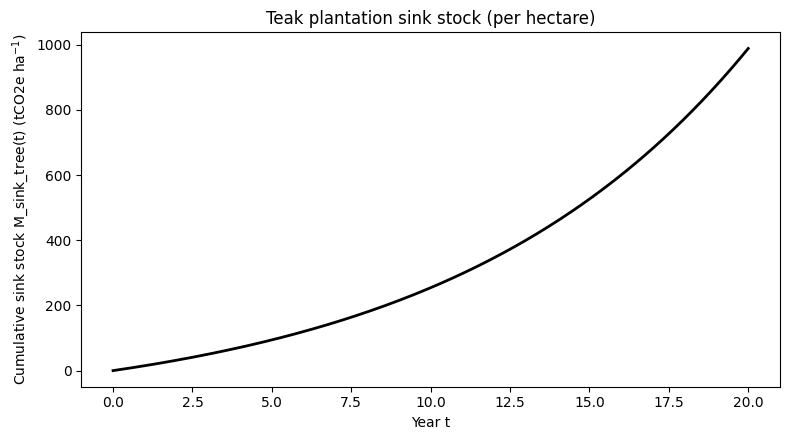

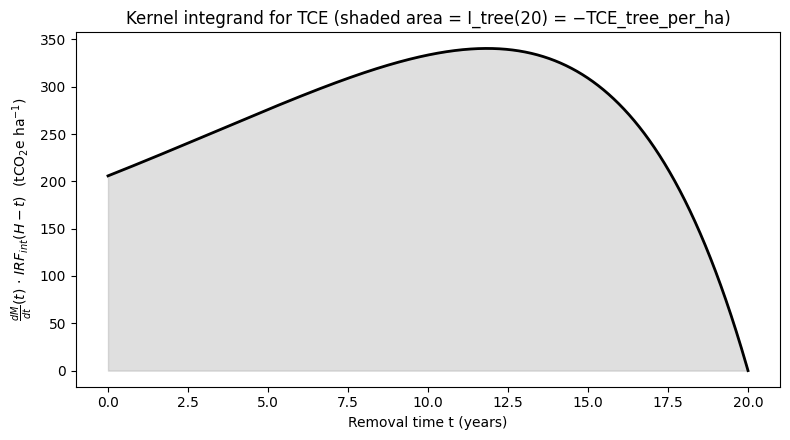

This curve shows the IRF-weighted contribution of removals at time t to the total climate effect at horizon H. The shaded area equals the total climate effect (TCE).


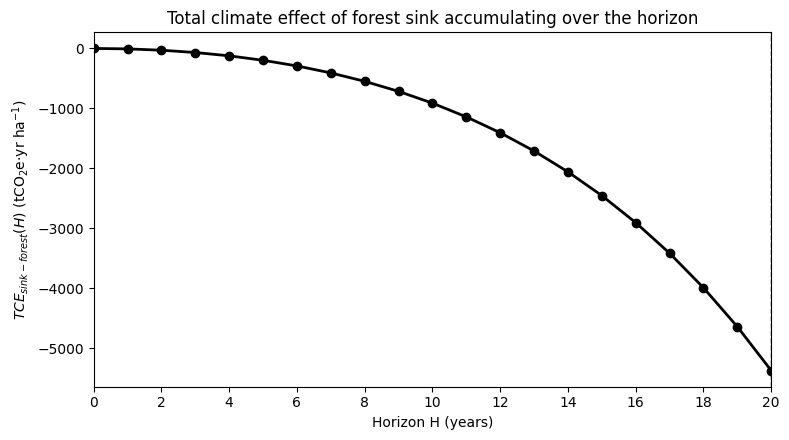

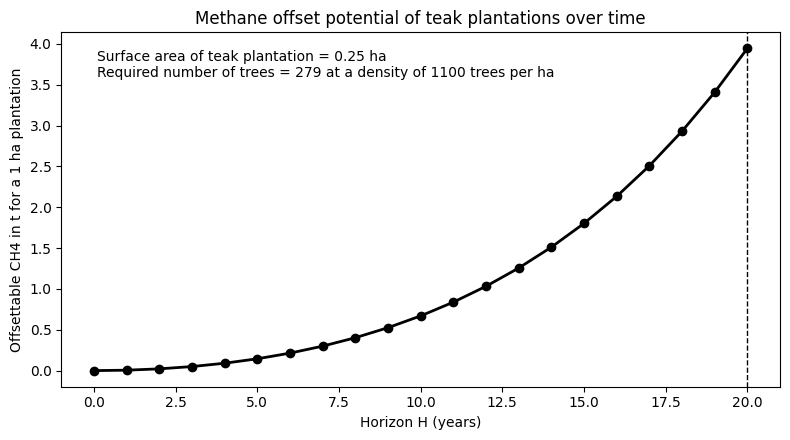


--- Methane offset potential per hectare ---
M_CH4-offset(20) per ha = 3.943724 tCH4 ha^-1


In [25]:
# Printing diagrams
# =============================================================================
# ## PLOT 1: CUMULATIVE SINK STOCK (per hectare)
# =============================================================================

# force white background + black text for this plot
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "text.color": "black"
})

fig, ax = plt.subplots(figsize=(8, 4.5))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

tt = np.linspace(0.0, float(H), 400)
ax.plot(tt, M_sink_tree(tt, M0=M0, k=k), color="black", linewidth=2)

ax.set_xlabel("Year t")
ax.set_ylabel("Cumulative sink stock M_sink_tree(t) (tCO2e ha$^{-1}$)")
ax.set_title("Teak plantation sink stock (per hectare)")

ax.tick_params(axis='both', colors='black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.title.set_color('black')
for spine in ax.spines.values():
    spine.set_color('black')

plt.tight_layout()
plt.show()


# =============================================================================
# ## PLOT 2: IRF-WEIGHTED INTEGRAND AND SHADED AREA (equals I_tree(H))
# =============================================================================
fig, ax = plt.subplots(figsize=(8, 4.5))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.plot(t, integrand, color="black", linewidth=2)
ax.fill_between(t, integrand, color="grey", alpha=0.25)

ax.set_xlabel("Removal time t (years)")
ax.set_ylabel(r"$\frac{dM}{dt}(t)\,\cdot\,IRF_{int}(H-t)$  (tCO$_2$e ha$^{-1}$)")
ax.set_title(f"Kernel integrand for TCE (shaded area = I_tree({H}) = −TCE_tree_per_ha)")
ax.tick_params(axis='both', colors='black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.title.set_color('black')
for spine in ax.spines.values():
    spine.set_color('black')

plt.tight_layout()
plt.show()
print("This curve shows the IRF-weighted contribution of removals at time t to the total climate effect at horizon H. The shaded area equals the total climate effect (TCE).")

# =============================================================================
# ## PLOT 3: TCE_forest(H) accumulating over the horizon
# TCE_forest(h) = - ∫_0^h dM/dt(t) * IRF_int(h-t) dt   for h = 1..H
# =============================================================================

H_vals = np.arange(0, H+1)
TCE_forest_by_H = np.zeros_like(H_vals, dtype=float)
n_plot = 50_000

for i, h in enumerate(H_vals):
    if h == 0:
        TCE_forest_by_H[i] = 0.0
        continue

    tt = np.linspace(0.0, float(h), n+1)
    integrand_h = dM_tree_dt(tt, M0=M0, k=k) * IRF_int(h - tt)
    I_h = trapz(integrand_h, tt)
    TCE_forest_by_H[i] = -I_h

TCE_forest_by_H = np.array(TCE_forest_by_H)

fig, ax = plt.subplots(figsize=(8, 4.5))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.plot(H_vals, TCE_forest_by_H, marker="o", linewidth=2, color="black")
ax.axvline(H, linestyle="--", color="black", linewidth=1)

ax.set_xlabel("Horizon H (years)")
ax.set_ylabel(r"$TCE_{sink-forest}(H)$ (tCO$_2$e·yr ha$^{-1}$)")
ax.set_title("Total climate effect of forest sink accumulating over the horizon")

ax.set_xlim(0, H)
ax.set_xticks(np.arange(0, H+1, 2))   # or step=5
ax.tick_params(axis='both', colors='black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.title.set_color('black')
for spine in ax.spines.values():
    spine.set_color('black')

plt.tight_layout()
plt.show()

# =============================================================================
# ## PLOT 4: Methane offset potential per ha accumulating over the horizon
# =============================================================================
# Using Eq. (19):
# M_CH4_offsettable(H) = -TCE_forest(H) / (GWP100_CH4 * IRF_int(100))
# Units: (tCO2e·yr/ha) / (tCO2e/tCH4 * yr) = tCH4/ha

M_CH4_offset_per_ha_by_H = (-TCE_forest_by_H) / (GWP100_CH4 * IRF100)
fig4 = plt.figure(figsize=(8, 4.5))
plt.plot(H_vals, M_CH4_offset_per_ha_by_H, marker="o", color="black", linewidth=2)
plt.axvline(H, linestyle="--", color="black", linewidth=1)

plt.xlabel("Horizon H (years)")
plt.ylabel("Offsettable CH4 in t for a 1 ha plantation")
plt.title("Methane offset potential of teak plantations over time")
A_round=round(A_req,2)
N_trees=round(N_trees+0.5,0)
plt.text(
            0.05, 0.95,
            f"Surface area of teak plantation = {A_round:.2f} ha\nRequired number of trees = {N_trees:.0f} at a density of {tree_density} trees per ha",
            transform=plt.gca().transAxes,
            va="top"
        )

plt.tight_layout()
fig4.savefig("../figures/figure_CH4_forest_offset.jpg", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

print("\n--- Methane offset potential per hectare ---")
print(f"M_CH4-offset({H}) per ha = {M_CH4_offset_per_ha_by_H[-1]:.6f} tCH4 ha^-1")

